<a href="https://colab.research.google.com/github/rromerov/Machine-Learning-Projects/blob/main/Credit_Card_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt
import seaborn as sns

Carga los datos y sustituye los nombres de las columnas del alemán al inglés de acuerdo a como se indica en la página de la UCI. 


In [ ]:
file="https://raw.githubusercontent.com/rromerov/Machine-Learning-Projects/main/SouthGermanCredit.asc"
credit=pd.read_table(file,sep=" ")

In [ ]:
credit.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [ ]:
columns_name=["status","duration","credit_history","purpose","amount","savings","employment_duration","installment_rate","personal_status_sex","other_debtors","present_residence","property","age","other_installment_plans","housing","number_credits","job","people_liable","telephone","foreign_worker","credit_risk"]
credit.columns=columns_name

In [ ]:
credit.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


Realiza una partición de los datos en el conjunto de entrenamiento del 85% y el de prueba de 15%. Los modelos se estarán entrenando con el método de validación cruzada, así que no es necesario en este paso generar el conjunto de validación. Define como la variable X a todas las variables de entrada y a la variable Y como la variable de salida. 


In [ ]:
X=credit.iloc[:,:-1:]
y=credit.iloc[:,-1]

In [ ]:
X.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,2,1,2
1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,1,1,2
2,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,2,1,2
3,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,2,1,1


In [ ]:
X_tv,X_test,y_tv,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

 Como una primera aproximación (baseline) realizarás las siguientes transformaciones mínimas
para generar los primeros modelos. En la misma página de la UCI se indica el tipo de variable de
cada uno de los factores. Definen cuatro tipo de variables: categórica (categorical), ordinal
(discretized quantitative), numérica (quantitative) y binaria (binary). Con base a dicha
información realiza un Pipeline que incluya al menos las siguientes transformaciones:

a. Imputación a todas las variables de entrada, diferenciando entre el tipo de cada variable
(decide y justifica que tipo de imputación realizas en cada caso).

b. Realiza un análisis de las variables numéricas (quantitative) de entrada y aplica una transformación que escale a todas ellas en un rango equiparable.



c. Aplica la transformación One-Hot encoding a las variables de entrada de tipo categórico y binaria. En particular, justifica por qué una variable binaria requeriría que se le aplique la
transformació

In [ ]:
numeric_features=["duration","amount","age"]
numeric_pipeline = Pipeline(
    steps=[("Mednum", SimpleImputer(strategy="median")), ("Stdnum",StandardScaler())]
)

categorical_features =["status","credit_history","purpose","savings","personal_status_sex","other_debtors","other_installment_plans","housing"]
categorical_pipeline=Pipeline(
    steps=[("Modacat", SimpleImputer(strategy="most_frequent")),("OHEcat",OneHotEncoder(handle_unknown="ignore"))]
)

ordinal_features=["employment_duration","installment_rate","present_residence","property","number_credits","job"]
ordinal_pipeline=Pipeline(
    steps=[("Modaord",SimpleImputer(strategy="most_frequent")),("OHEord",OneHotEncoder(handle_unknown="ignore"))]
)


binary_features=["people_liable","telephone","foreign_worker"]
binary_pipeline=Pipeline(
    steps=[("Modabi",SimpleImputer(strategy="most_frequent")),("OHEbi", OneHotEncoder(handle_unknown="ignore"))]
)

columnasTransformer = ColumnTransformer(transformers = [('numpipe', numeric_pipeline, numeric_features),
                                                        ('catpipe', categorical_pipeline, categorical_features),
                                                        ('ordpipe', ordinal_pipeline, ordinal_features),
                                                        ('binpipe', binary_pipeline, binary_features)])

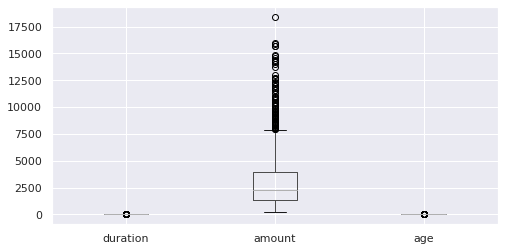

In [ ]:
numeric_values=credit[numeric_features].copy()
numeric_values.boxplot()

In [ ]:
for col in credit.columns:

    col_min = credit[col].min()

    col_mean = credit[col].mean()

    col_3q = credit[col].quantile(0.75)

    col_max = credit[col].max()

    print(f'Column {col:30s} : min:{col_min:5}, mean:{col_mean:10}, 3Q:{col_3q:10}, max:{col_max:5}.')

Column status                         : min:    1, mean:     2.577, 3Q:       4.0, max:    4.
Column duration                       : min:    4, mean:    20.903, 3Q:      24.0, max:   72.
Column credit_history                 : min:    0, mean:     2.545, 3Q:       4.0, max:    4.
Column purpose                        : min:    0, mean:     2.828, 3Q:       3.0, max:   10.
Column amount                         : min:  250, mean:  3271.248, 3Q:   3972.25, max:18424.
Column savings                        : min:    1, mean:     2.105, 3Q:       3.0, max:    5.
Column employment_duration            : min:    1, mean:     3.384, 3Q:       5.0, max:    5.
Column installment_rate               : min:    1, mean:     2.973, 3Q:       4.0, max:    4.
Column personal_status_sex            : min:    1, mean:     2.682, 3Q:       3.0, max:    4.
Column other_debtors                  : min:    1, mean:     1.145, 3Q:       1.0, max:    3.
Column present_residence              : min:    1, mean:    

In [ ]:
credit[["credit_risk"]].value_counts()

credit_risk
1              700
0              300
dtype: int64

4. Llevarás un entrenamiento usando validación cruzada entre los siguientes tres modelos de
aprendizaje automático: Regresión Logística, Árbol de Decisión y Bosque Aleatorio. Deberás
llevar a cabo el entrenamiento de los tres de manera conjunta usando un ciclo FOR. Recuerda
aplicar las transformaciones que definiste en tu Pipeline. El entrenamiento debe ser con las
siguientes características:
  
  a. Usa los parámetros predeterminados de cada modelo.
  
  b. En cada iteración deben calcularse todas las siguientes métricas: accuracy, precision,
recall, f1-score y Gmean. Todas estas métricas deben ser funciones que tú mismo debes
definir (Es decir, no usar las funciones de dichas métricas que te proporciona scikit-learn.
Sin embargo, sí puedes usar la información regresada por el método confusion_matrix()
de scikit-learn para definir las métricas).
 
  c. Usar validación cruzada estratificada con 5 particiones y con 3 repeticiones.
 
  d. Imprimir el valor de todas estas métricas, tanto para los datos de entrenamiento, como
para los de validación. Así como los diagramas de caja y bigotes de los tres modelos con la
métrica “recall”. ¿Alguno de los modelos está subentrenado o sobreentrenado? Justifica tu
respuesta.
 
  e. En particular obtengamos algunas de las llamadas curvas de aprendizaje para algunos de
estos casos. En dada gráfico debes incluir tus comentarios sobre el modelo generado:
   
    i. Obtener las curvas de aprendizaje (learning_curve) en la cual se va incrementando el tamaño de la muestra para el modelo de regresión Logística con su hiperparámetros predeterminados. Utilizar al menos 20 puntos en la partición de los conjuntos de entrenamiento y la métrica “f1-score”, como evaluación del desempeño de dicha función “learning_curve()”.
   
    ii. Obtener las curvas de validación (validation_curve) en la cual se va incrementando la complejidad del hiperparámetro “max_depth” para el modelo de árbol de decisión con sus hiperparámetros predeterminados. Utilizar valores de máxima profundidad desde 1 hasta 20 y con la métrica “f1-score” para la evaluación del desempeño del modelo.
   
    iii. Obtener las curvas de aprendizaje (learning_curve) en la cual se va incrementando el tamaño de la muestra para el modelo de regresión bosque aleatorio (random forest) con su hiperparámetros predeterminados. Utilizar al menos 20 puntos en la partición de los conjuntos de entrenamiento y la métrica “recall”, como evaluación del desempeño del modelo.

In [ ]:
def mi_accuracy(yreal,ypred):
  VN,FP,FN,VP=confusion_matrix(yreal,ypred).flatten()
  accuracy=(VN+VP)/(VN+FP+FN+VP)
  return accuracy

def mi_precission(yreal,ypred):
  VN,FP,FN,VP=confusion_matrix(yreal,ypred).flatten()
  precision=(VP)/(VP+FP)
  return precision

def mi_recall(yreal,ypred):
  VN,FP,FN,VP=confusion_matrix(yreal,ypred).flatten()
  recall=(VP)/(VP+FN)
  return recall

def mi_f1score(yreal,ypred):
    VN,FP,FN,VP=confusion_matrix(yreal,ypred).flatten()
    recall=(VP)/(VP+FN)
    precision=(VP)/(VP+FP)
    f1score=(2*recall*precision)/(precision+recall)
    return f1score

def mi_gmean(yreal,ypred):
    VN,FP,FN,VP=confusion_matrix(yreal,ypred).flatten()
    recall=(VP)/(VP+FN)
    specifity=(VN)/(VN+FP)
    gmean=np.sqrt(recall*specifity)
    return gmean


In [ ]:
def get_models():
  modelos = list()
  nombres = list()

  # LR - Regresión Logística:
  modelos.append(LogisticRegression())
  nombres.append('LR')

  # DT - Árbol de Decisión:
  modelos.append(DecisionTreeClassifier())
  nombres.append('DT')

  # RF . Bosque Aleatorio
  modelos.append(RandomForestClassifier())
  nombres.append('RF')

  return modelos, nombres


In [ ]:
modelos, nombres = get_models()  # cargamos los modelos a comparar
resultadosLDR = list()   

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  mismetricas={"accuracy":make_scorer(mi_accuracy),"precission":make_scorer(mi_precission),"recall":make_scorer(mi_recall),"f1score":make_scorer(mi_f1score),"gmean":make_scorer(mi_gmean)}
  kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
  resultados = cross_validate(pipeline, X_tv, y_tv, scoring=mismetricas, cv=kfold, error_score="raise",return_train_score=True)
  resultadosLDR.append(resultados)  
  print("Prueba \n") 
  print('%s:\nmean Accuracy: %.3f (%.4f)\nmean Precission: %.3f (%.4f)\nmeanRecall: %.3f (%.4f)\nmean F1-Score: %.3f (%.4f)\nGmean: %.3f (%.4f)\n' % (nombres[i],
                                                                          np.mean(resultados['test_accuracy']),
                                                                          np.std(resultados['test_accuracy']), 
                                                                          np.mean(resultados['test_precission']),
                                                                          np.std(resultados['test_precission']),
                                                                          np.mean(resultados['test_recall']),
                                                                          np.std(resultados['test_recall']), 
                                                                          np.mean(resultados['test_f1score']),
                                                                          np.std(resultados['test_f1score']),                                                                           
                                                                          np.mean(resultados['test_gmean']),
                                                                          np.std(resultados['test_gmean']),                                                                            
                                                                          ))
  print("Entrenamiento \n") 
  print('%s:\nmean Accuracy: %.3f (%.4f)\nmean Precision: %.3f (%.4f)\nmean Recall: %.3f (%.4f)\nmean F1score: %.3f (%.4f)\nGmean: %.3f (%.4f)\n' % (nombres[i], 
                                                                          np.mean(resultados['train_accuracy']), np.std(resultados['train_accuracy']),  
                                                                          np.mean(resultados['train_precission']), np.std(resultados['train_precission']), 
                                                                          np.mean(resultados['train_recall']), np.std(resultados['train_recall']),
                                                                          np.mean(resultados['train_f1score']), np.std(resultados['train_f1score']), 
                                                                          np.mean(resultados['train_gmean']), np.std(resultados['train_gmean']) ))

Prueba 

LR:
mean Accuracy: 0.753 (0.0256)
mean Precission: 0.796 (0.0173)
meanRecall: 0.869 (0.0270)
mean F1-Score: 0.831 (0.0184)
Gmean: 0.650 (0.0358)

Entrenamiento 

LR:
mean Accuracy: 0.799 (0.0078)
mean Precision: 0.825 (0.0057)
mean Recall: 0.902 (0.0079)
mean F1score: 0.862 (0.0055)
Gmean: 0.711 (0.0113)

Prueba 

DT:
mean Accuracy: 0.675 (0.0345)
mean Precission: 0.773 (0.0223)
meanRecall: 0.755 (0.0524)
mean F1-Score: 0.763 (0.0305)
Gmean: 0.606 (0.0412)

Entrenamiento 

DT:
mean Accuracy: 1.000 (0.0000)
mean Precision: 1.000 (0.0000)
mean Recall: 1.000 (0.0000)
mean F1score: 1.000 (0.0000)
Gmean: 1.000 (0.0000)

Prueba 

RF:
mean Accuracy: 0.764 (0.0249)
mean Precission: 0.786 (0.0203)
meanRecall: 0.909 (0.0229)
mean F1-Score: 0.843 (0.0163)
Gmean: 0.624 (0.0476)

Entrenamiento 

RF:
mean Accuracy: 1.000 (0.0000)
mean Precision: 1.000 (0.0000)
mean Recall: 1.000 (0.0000)
mean F1score: 1.000 (0.0000)
Gmean: 1.000 (0.0000)



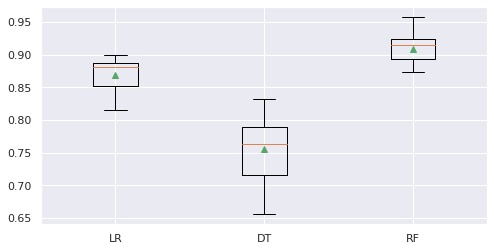

In [ ]:
sns.set(rc={'figure.figsize':(8,4)})

bpRecall = list()
for i in range(len(resultadosLDR)):
  rr = resultadosLDR[i]['test_recall']
  bpRecall.append(rr)

plt.boxplot(bpRecall, labels=nombres, showmeans=True)
plt.show()

In [ ]:
def mi_LearningCurvePlot(train_sizes, train_scores, val_scores):

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    plt.title('Curvas de Aprendizaje incrementando el tamaño de la muestra')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('F1-Score')
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()

In [ ]:
def mi_ModeloYCurvas(Xin):

       modeloL = LogisticRegression(max_iter=2500, random_state=1)

       mi_pipe =  Pipeline(steps=[("ct", columnasTransformer), ("modelo", modeloL)])

       mi_kfold = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=7)
       
       delta_train_sz = np.linspace(0.1,1.0,40)

       tr_sizes, tr_scores, val_scores = learning_curve(estimator = mi_pipe ,    
                                                        X = Xin,
                                                        y = y_tv,
                                                        cv = mi_kfold ,
                                                        train_sizes = delta_train_sz ,
                                                        scoring=make_scorer(mi_f1score),
                                                        random_state=10)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)


Curvas de aprendizaje del modelo lineal:


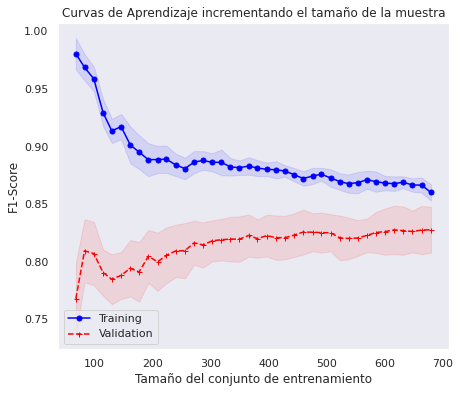

In [ ]:
print('Curvas de aprendizaje del modelo lineal:')
mi_ModeloYCurvas(X_tv)

In [ ]:
def mi_ValidationCurvePlot(train_scores,test_scores,parameter_range):

  mean_train_score = np.mean(train_scores, axis = 1)
  std_train_score = np.std(train_scores, axis = 1)
  
  mean_test_score = np.mean(test_scores, axis = 1)
  std_test_score = np.std(test_scores, axis = 1)
  plt.figure(figsize=(7,6))

  plt.plot(parameter_range, mean_train_score,
      label = "Training", color = 'blue', marker='o', markersize=5)
  plt.fill_between(parameter_range, mean_train_score - std_train_score, mean_train_score + std_train_score, color="blue",alpha=0.1)
  
  plt.plot(parameter_range, mean_test_score,
    label = "Validation", color = 'red', marker='+', markersize=5, linestyle='--')
  plt.fill_between(parameter_range, mean_test_score - std_test_score, mean_test_score + std_test_score, color="red",alpha=0.1)

  plt.title("Curva de validación")
  plt.xlabel("Tamaño del conjunto de validación")
  plt.ylabel("F1-Score")
  plt.tight_layout()
  plt.legend(loc = 'best')
  plt.show()

In [ ]:
def mi_ModeloValidacion(Xin,param_name_dt):

       modeloDT = DecisionTreeClassifier()
       pipeDT =  Pipeline(steps=[("ct", columnasTransformer), ("model", modeloDT)])
       kfoldDT = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=7)
       range = np.linspace(1, 20, 20)
       tr_scores, val_scores = validation_curve(estimator =pipeDT ,    
                                                        X = Xin,
                                                        y = y_tv,
                                                        cv = kfoldDT ,
                                                        param_name=f"model__{param_name_dt}",
                                                        param_range = range ,
                                                        scoring=make_scorer(mi_f1score))
       
       mi_ValidationCurvePlot(tr_scores, val_scores,range)

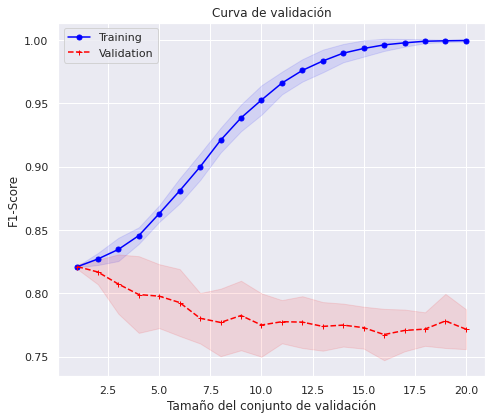

In [ ]:
mi_ModeloValidacion(X_tv,"max_depth")

In [ ]:
def mi_ModeloRandomForest(Xin):

       modelo = RandomForestClassifier()
       mi_pipe =  Pipeline(steps=[("ct", columnasTransformer), ("modelo", modelo)])
       mi_kfold = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=7)
       delta_train_sz = np.linspace(0.1,1.0,20)

       tr_sizes, tr_scores, val_scores = learning_curve(estimator = mi_pipe ,    
                                                        X = Xin,
                                                        y = y_tv,
                                                        cv = mi_kfold ,
                                                        train_sizes = delta_train_sz ,
                                                        scoring=make_scorer(mi_recall),
                                                        random_state=10)

       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de validación del árbol de decisión:


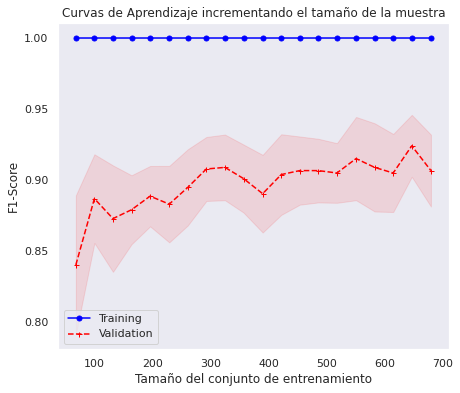

In [ ]:
print('Curvas de validación del árbol de decisión:')
mi_ModeloRandomForest(X_tv)

5. Finalmente veamos la manera de mejorar los valores de los hiperparámetros de cada modelo, así 
como el problema del sobreentrenamiento de algunos de ellos. Para ello deberás usar el método 
GridSearchCV() de scikit-learn. Recuerda que este método hace una búsqueda de los mejores 
hiperparámetros de un modelo mediante el llamada formato de malla y aplicando validación 
cruzada. En cada caso puedes incrementar el máximo de iteraciones,”max_iter” para que tengas 
la convergencia adecuada para todas las combinaciones en cada modelo. Recuerda también 
aplicar las transformaciones que definiste en tu Pipeline. Para fines de este ejercicio se ha 
seleccionado para cada modelo una métrica diferente, que permita irte familiarizando con ellas. 
Puedes consultar su documentación de GridSearchCV en la siguiente liga: 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 

a. Para el modelo de regresión logística realizar el entrenamiento buscando sus mejores 
hiperparámetros con GridSearchCV(). Los hiperparámetros que debes incluir en su 
búsqueda deben ser al menos los siguientes: C, solver, class_weight y penalty. En este caso 
deberás usar la métrica (scoring) “f1-score”. Imprime la mejor combinación de 
parámetros obtenidos, así como el valor del mejor desempeño (score) obtenido con la 
métrica f1. ¿Cuál es la utilidad de la métrica “f1-score”? Incluye tus conclusiones. 
NOTA: Toma en cuenta que no todas las combinaciones de “solver” y “penalty” son 
posibles, para que lo tomes en cuenta al momento de realizar la búsqueda. Revisa la 
documentación. 


In [ ]:
logmodel=LogisticRegression(max_iter=9000,random_state=1)
log_pipe=Pipeline(steps=[("Col", columnasTransformer),("model", logmodel)])
log_kfold=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7) 

paramc=[0.01, 0.1, 1, 10, 100, 1000]

paramgr=[{'model__penalty': ['l1'], 'model__solver': [ 'saga','liblinear'], 'model__class_weight':['balanced', None], 'model__C': paramc},
                  {'model__penalty': ['l2'], 'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'model__class_weight':['balanced', None], 'model__C': paramc},
                  {'model__penalty': ['elasticnet'], 'model__solver': ['saga'], 'model__class_weight':['balanced', None], 'model__C': paramc, 'model__l1_ratio': [0.5]},
                 ]

gridLog=GridSearchCV(estimator =  log_pipe, 
                            param_grid = paramgr,
                            scoring = make_scorer(mi_f1score), 
                            cv = log_kfold,
                     n_jobs=-1)

gridLog.fit(X_tv,np.ravel(y_tv))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.82107843 0.82107843 0.74997717 0.75388479
 0.82310436 0.82385929 0.78441772 0.78480657 0.83192153 0.83192221
 0.77743873 0.77743873 0.82443268 0.82443268 0.77596105 0.77596105
 0.82158262 0.82158262 0.77596105 0.77596105 0.82158262 0.82158262
 0.78353567 0.78353567 0.78304725 0.78341532 0.78341532 0.82908728
 0.82908728 0.82610411 0.82880708 0.82883737 0.78514526 0.78514526
 0.78439289 0.78439289 0.78439289 0.83845101 0.83845101 0.8392344
 0.83857505 0.83923992 0.78560947 0.78560947 0.78560947 0.78560947
 0.78560947 0.82784856 0.82784856 0.82774057 0.82774057 0.82774057
 0.77671187 0.77671187 0.77709031 0.77746327 0.77746327 0.82373786
 0.82373786 0.82373786 0.82373786 0.82373786 0.77596105 0.77596105
 0.77596105 0.77596105 0.77596105 0.82158262 0.82158262 0.82158262
 0.82158262 0.82158262 0.77596105 0.77596105 0.77596105 0.

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=7),
             estimator=Pipeline(steps=[('Col',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('Mednum',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('Stdnum',
                                                                                          StandardScaler())]),
                                                                         ['duration',
                                                                          'amount',
                                                                          'age']),
                                                                        ('catpipe',
              

In [ ]:
print("El mejor resultado es:",gridLog.best_score_)
print("El mejor parámetro es:",gridLog.best_params_)

El mejor resultado es: 0.8392399218133596
El mejor parámetro es: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'saga'}


b. Con los mejores valores de los hiperparámetros encontrados con la métrica “f1-score” 
para el modelo de regresión logística, obtener las curvas de aprendizaje (learning curve), 
incrementando el tamaño del conjunto de entrenamiento al menos 20 veces. Si lo crees 
adecuado, puedes hacer los ajustes que consideres adecuados para mejorar el resultado y 
evitar el sobreentrenamiento o el subentrenamiento. 


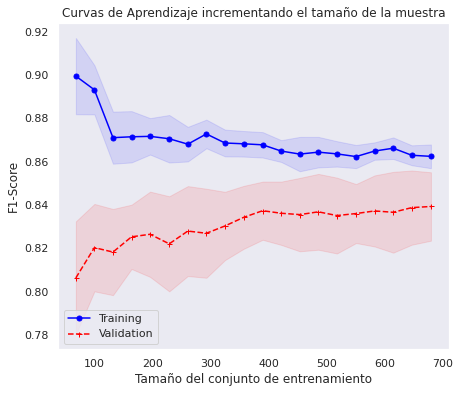

In [ ]:
bestLogmodel=LogisticRegression(C=gridLog.best_params_.get('model__C'),
                                solver=gridLog.best_params_.get('model__solver'),
                                penalty=gridLog.best_params_.get('model__penalty'),
                                max_iter=8000, 
                                random_state=1)
bestLog_pipe=Pipeline(steps=[("Col", columnasTransformer),("model", bestLogmodel)])
kfold_bestLog=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
train_size_bestLog=np.linspace(0.1, 1.0, 20)
tr_sizes, tr_scores, val_scores = learning_curve(estimator = bestLog_pipe ,    
                                                        X = X_tv,
                                                        y = y_tv,
                                                        cv = kfold_bestLog ,
                                                        train_sizes = train_size_bestLog ,
                                                        random_state=10,
                                                        scoring=make_scorer(mi_f1score))

mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)


c. Para el modelo de árbol de decisión (decision tree) realizar el entrenamiento buscando 
sus mejores hiperparámetros con GridSearchCV(). Los hiperparámetros que debes incluir 
en su búsqueda deben ser al menos los siguientes: ccp_alpha, criterion, max_depth, 
min_samples_split y class_weight. En este caso deberás usar la métrica (scoring) 
“precision”. Imprime la mejor combinación de parámetros obtenidos, así como el valor 
del mejor desempeño (score) obtenido con la métrica “precision”. ¿Cuál es la utilidad de 
la métrica “precision”? Incluye tus conclusiones. 

In [ ]:
modelo_arbol=DecisionTreeClassifier() 
modelo_arbol_pipe=Pipeline(steps=[("Col", columnasTransformer),("model", modelo_arbol)])
arbol_kfold=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7) 

paramgr = {'model__ccp_alpha':[0.01, 0.001, .0001, .00001,.000001,.0000001],  
              'model__criterion': ['gini', 'entropy'], 
              'model__max_depth':[2, 4, 6, 8, 10, 12], 
              'model__min_samples_split':[2, 4, 6,8,10], 
              'model__class_weight': ['balanced', None]}

gridarbol=GridSearchCV(estimator=modelo_arbol_pipe,
                       param_grid=paramgr,
                       scoring=make_scorer(mi_precission),
                       cv=arbol_kfold)
gridarbol.fit(X_tv,np.ravel(y_tv))        

KeyboardInterrupt: ignored

In [ ]:
print("El mejor resultado es:",gridarbol.best_score_)
print("El mejor parámetro es:",gridarbol.best_params_)

d. Con los mejores valores de los hiperparámetros encontrados con la métrica “precision” 
para el modelo de árbol de decisión, obtener las curvas de aprendizaje (learning curve), 
incrementando el tamaño del conjunto de entrenamiento al menos 20 veces. Si lo crees 
adecuado, puedes hacer los ajustes que consideres adecuados para mejorar el resultado y 
evitar el sobreentrenamiento o el subentrenamiento.

In [ ]:
modeload = DecisionTreeClassifier(ccp_alpha=gridarbol.best_params_.get('model__ccp_alpha'),
                                    criterion=gridarbol.best_params_.get('model__criterion'),
                                    max_depth=gridarbol.best_params_.get('model__max_depth'),
                                    min_samples_split=gridarbol.best_params_.get('model__min_samples_split'))

ad_pipe = Pipeline(steps=[("Colum Transformer", columnasTransformer),("ModeloDecisionTree", modeload)])
ad_kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)  
delta_train_sz = np.linspace(.1, 1, 40) 
tr_sizes, tr_scores, val_scores = learning_curve(estimator = ad_pipe ,    
                                                      X = X_tv,
                                                      y = y_tv,
                                                      cv = ad_kfold ,
                                                      train_sizes = delta_train_sz ,
                                                      random_state=10,
                                                      scoring=make_scorer(mi_precission)) 

mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

e. Para el modelo de bosque aleatorio (random forest) realizar el entrenamiento buscando 
sus mejores hiperparámetros con GridSearchCV(). Los hiperparámetros que debes incluir 
en su búsqueda deben ser al menos los siguientes: ccp_alpha, criterion, max_depth, 
min_samples_split y class_weight. En este caso deberás usar la métrica (scoring) “recall”. 
Imprime la mejor combinación de parámetros obtenidos, así como el valor del mejor 
desempeño (score) obtenido con la métrica “recall”. ¿Cuál es la utilidad de la métrica 
“recall”? Incluye tus conclusiones. 
NOTA: Toma en cuenta que el método de random forest pude tardar varios minutos en 
llevar a cabo 

In [ ]:
modelo_rf=RandomForestClassifier() 
modelo_rf_pipe=Pipeline(steps=[("Col", columnasTransformer),("model", modelo_rf)])
rf_kfold=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7) 

# paramgr = {'model__max_depth':[1,2,3,4,5],  
#               'model__criterion': ["gini", "entropy", "log_loss"], 
#               'model__ccp_alpha':[2, 4, 6, 8, 10, 12], 
#               'model__min_samples_split':[2, 4, 6,8,10], 
#               'model__class_weight': ['balanced',"balanced_subsample", None]
#            }

paramgr=[
    {"max_depth":[1,2,3,4,5], 
     "criterion":["gini", "entropy", "log_loss"],
     "ccp_alpha":[0.01,0.001,0.0001,0.00001],
     "min_samples_split":[2, 4, 6,8,10],
     "class_weight": ['balanced',"balanced_subsample", None]
     }
]

gridrf=GridSearchCV(estimator=modelo_rf,
                       param_grid=paramgr,
                       scoring=make_scorer(mi_recall),
                       cv=rf_kfold)
gridrf.fit(X_tv, np.ravel(y_tv))       

In [ ]:
print("El mejor resultado es:",gridrf.best_score_)
print("El mejor parámetro es:",gridrf.best_params_)

f. Con los mejores valores de los hiperparámetros encontrados con la métrica “recall” para 
el modelo de bosque aleatorio, obtener las curvas de validación (validation curve), 
incrementando la complejidad del modelo a través del hiperparámetro “max_depth” con 
al menos 10 valores. Si lo crees adecuado, puedes hacer los ajustes que consideres 
adecuados para mejorar el resultado y evitar el sobreentrenamiento o el 
subentrenamiento. 


In [ ]:
modelo_best_RF = RandomForestClassifier(ccp_alpha=gridrf.best_params_.get('ccp_alpha'),
                                 criterion=gridrf.best_params_.get('criterion'),
                                 max_depth=10,
                                 min_samples_split=gridrf.best_params_.get('min_samples_split'))
mi_pipe = Pipeline(steps=[("PreparaInfo", columnasTransformer),("ModeloRandomForest", modelo_best_RF)])
mi_kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3) 
delta_train_sz = np.linspace(1,20,20, dtype=int) 



tr_scores, val_scores = validation_curve(n_jobs = 2, 
                                  estimator = mi_pipe, 
                                  X = X_tv,
                                  y = np.ravel(y_tv),
                                  param_name = f"ModeloRandomForest__max_depth", 
                                  param_range = delta_train_sz,
                                  cv = mi_kfold, 
                                  scoring = 'recall',
                                
                                  )
mi_LearningCurvePlot(delta_train_sz, tr_scores, val_scores)

6. Para cada uno de estos tres modelos, con las métricas que se consideraron en cada caso y usando 
el conjunto de Prueba que no has utilizado hasta ahora, obtener los modelos finales como se te 
indica a continuación. Deberás usar además como conjunto de entrenamiento el llamado modelo 
de entrenamiento “aumentado” que consiste en las datos que estuviste utilizando para 
entrenamiento y validación: 

a. Obtener el modelo de regresión logística con los mejores parámetros que hayas 
encontrado con la métrica f1-score utilizada. Imprimir el valor de dicha métrica e incluye 
tus conclusiones finales para este caso. Incluir un gráfico del árbol de decisión final 
obtenido. 

In [ ]:
estimatorLog=gridLog.best_estimator_
predictions = estimatorLog.predict(X_tv)
print("Métrica f1-score: %.3f \n" %(mi_f1score(y_tv, predictions)))

 Obtener el modelo de árbol de decisiones con los mejores parámetros que hayas 
encontrado con la métrica “precision” utilizada. Imprimir el valor de dicha métrica e 
incluye tus conclusiones finales para este caso. 


In [ ]:
estimatorDT= gridarbol.best_estimator_

predictions = estimatorDT.predict(X_tv)
print("Métrica precission: %.3f \n" %(mi_precission(y_tv, predictions)))
plt.figure(figsize=(30,10))
tree.plot_tree(estimatorDT.named_steps["model"], filled = True)

c. Obtener el modelo de bosque aleatorio con los mejores parámetros que hayas 
encontrado con la métrica “recall” utilizada. Imprimir el valor de dicha métrica e incluye 
tus conclusiones finales para este caso. 

In [ ]:
estimatorRF=gridrf.best_estimator_
predictions=gridrf.predict(X_tv)

print("Métrica recall: %.3f \n" %(mi_recall(y_tv, predictions)))